# Surfzone Drifter Release
## SWASH 2D + OpenDrifter Approacher?

Consider a case where small drifters are released from a groyned beach. What is their chance of propagating into deep water? To explore this problem, a case study region must be specified. Consider the beach of Arish, Egypt:

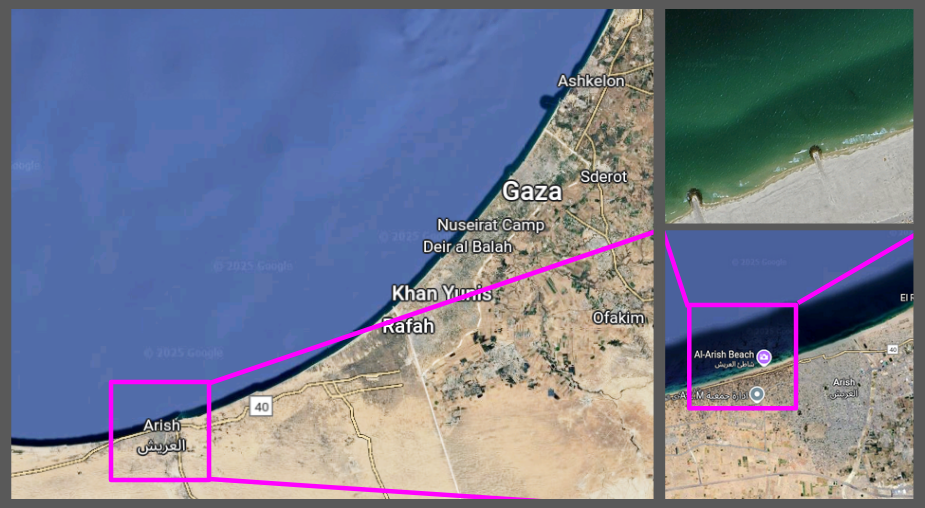

Note: Groynes are spaced approximatly 160 meters apart, and are about 10 meters wide, and appear to extend around 20m seaward from the beach. 

## Model Assumptions

Because 2D is expensive to run, and we care about transport from 0 to 50 m depth, let's break the domain into 2 zones:

### Zone 1: Immediate Coastal Area
From 0 to 2 meters depth (400 m offshore) I'll use 2D, to resolve currents around the groynes. Here I'll assume shallow water flows only (therefore making depth-averaged currents acceptable). 

### Zone 2: Intermediate Coastal Area
From 2 to 50 meters depth (30 km) I'll use quasi-1D SWASH, to balance wind and stokes drift. Here I'll assume linear waves 

In all cases, SWASH will be initialized in a 2D configuration, repeating alongshore. 

## Bathymetry

The Pan-European infrastructure for ocean & marine data management provides local bathymetry. Data were accessed from https://cdi.seadatanet.org/search

Let's take a look:

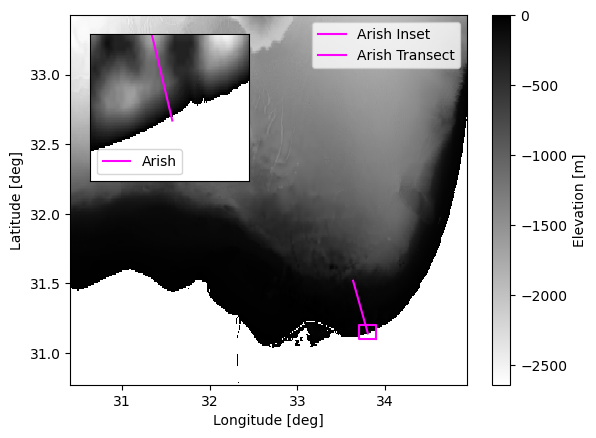

In [3]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

ncf = '/home/cassandra/Documents/levantine.nc'
nc = xr.open_dataset(ncf)

# Get the data
lons = nc.longitude.values
lats = nc.latitude.values
data = nc.elevation.values

# Onshore / offshore points near Arish
lon0 = 33.803528852801264
lat0 = 31.141287684857176
lon1 = 33.63495260430966
lat1 = 31.519644739808285
        
# Arish Inset
lonmin = 33.7
lonmax = 33.9
latmin = 31.1
latmax = 31.2

# Area around Arish
lon_ok = np.logical_and(lons > lonmin, lons < lonmax)
lat_ok = np.logical_and(lats > latmin, lats < latmax)

# Plot
plt.figure()
ax = plt.subplot(111)
m = plt.pcolormesh(lons[::10], lats[::10], data[::10][:,::10], shading='nearest', cmap='binary')
cb = plt.colorbar(m)
cb.ax.set_ylabel("Elevation [m]")
plt.xlabel("Longitude [deg]")
plt.ylabel("Latitude [deg]")
plt.plot([lonmax, lonmin, lonmin, lonmax, lonmax], [latmin, latmin, latmax, latmax, latmin], color='magenta', label='Arish Inset')
plt.plot([lon0,lon1], [lat0,lat1], color='magenta', label='Arish Transect')
plt.legend()

# Inset
iax = ax.inset_axes([0.05, 0.55, 0.4, 0.4], xticks=[], yticks=[])
m = iax.pcolormesh(lons[lon_ok], lats[lat_ok], data[lat_ok][:,lon_ok], shading='nearest', cmap='binary')
iax.plot([lon0,lon1], [lat0,lat1], color='magenta', label='Arish')
iax.set_xlim(lons[lon_ok][0], lons[lon_ok][-1])
iax.set_ylim(lats[lat_ok][0], lats[lat_ok][-1])
iax.legend()

plt.show()

Let's sample the bathymetry near Arish to estimate a profile:

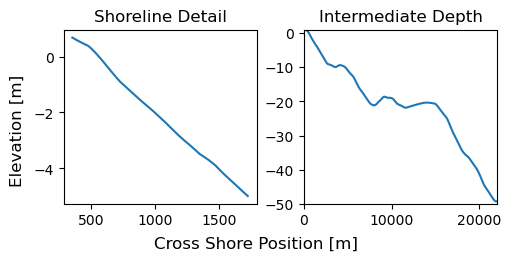

Approximate slope: -0.00436


In [15]:
import utm
import scipy.interpolate

# Assume a range of values using onshore/offshore coordinates
lonrange = np.linspace(lon0, lon1, num=10000)
latrange = np.linspace(lat0, lat1, num=10000)

# Interpolate
interp = scipy.interpolate.RegularGridInterpolator((lons, lats,), data.T, bounds_error=False, fill_value=None)
prof = interp(np.array([lonrange, latrange]).T)

# Convert from lat/lon to UTM coordinates
ux, uy, _, __ = utm.from_latlon(latrange, lonrange)

# And evaluate distance along transect
dx = np.sqrt((ux-ux[0])**2 + (uy - uy[0])**2)

# Plot
fig, axs = plt.subplots(ncols=2, constrained_layout=True, figsize=(5,2.5))
fig.supxlabel("Cross Shore Position [m]")
fig.supylabel("Elevation [m]")
pok = prof > -5
axs[0].set_title("Shoreline Detail")
axs[0].plot(dx[pok], prof[pok])
axs[1].set_title("Intermediate Depth")
axs[1].plot(dx, prof)
axs[1].set_xlim(0, 22000)
axs[1].set_ylim(-50, 1)
plt.show()

# Compute slope over first 500 m
x0 = 400
x1 = 900
h0 = np.interp(x0, dx, prof)
h1 = np.interp(x1, dx, prof)
slope = (h1 - h0)/500

print("Approximate slope: " + str(np.around(slope, 5)))

So, based on visual observations (160 meter groins, 10 m across and 20 m in extent), I'll estimate a simplified profile in 2D:

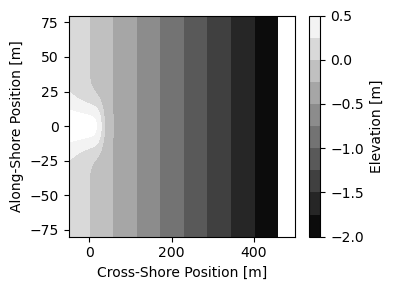

In [16]:
from scipy.ndimage import gaussian_filter

# Define model grid
xrange = np.linspace(-50, 500, 551)
yrange = np.linspace(-80, 80, 161)
xx, yy = np.meshgrid(xrange, yrange)

# Assume a plane beach
beta = -0.00436
zz = xx*beta

# Put the groin in. Make it bigger than realistic
is_groin = np.logical_and(xx < 30, np.abs(yy) < 10)
zz[is_groin] = 1.0

# Then smooth it down
zz_s = gaussian_filter(zz, 10, mode='nearest')

# Plot
plt.figure(figsize=(4,3))
cf = plt.contourf(xrange, yrange, zz_s, cmap='binary_r', levels=np.linspace(-2, 0.5, 11))
cb = plt.colorbar(cf)
cb.ax.set_ylabel("Elevation [m]")
plt.xlabel('Cross-Shore Position [m]')
plt.ylabel('Along-Shore Position [m]')
plt.tight_layout()
plt.show()


## Waves
I need realistic waves with direction and spread. Let's download those from Copernicus:

In [17]:
import copernicusmarine

# Note: you need an account for this, then call copernicusmarine.login(username="", password="") to create a credentials file. 
copernicusmarine.subset(
  dataset_id="cmems_mod_med_wav_anfc_4.2km_PT1H-i",
  variables=["VHM0", "VMDR", "VTPK"],
  minimum_longitude=33.0,
  maximum_longitude=34.0,
  minimum_latitude=30.5,
  maximum_latitude=31.5,
  start_datetime="2025-08-05",
  end_datetime="2025-08-10",
  output_directory="./data",
  output_filename="wave_forecast.nc"
)

INFO - 2025-08-04T01:31:27Z - Selected dataset version: "202311"
INFO - 2025-08-04T01:31:27Z - Selected dataset part: "default"
WARNING - 2025-08-04T01:31:27Z - The dataset cmems_mod_med_wav_anfc_4.2km_PT1H-i, version '202311', part 'default' is currently being updated. Data after 2025-08-03T00:00:00.000Z may not be up to date.
INFO - 2025-08-04T01:31:32Z - Starting download. Please wait...
INFO - 2025-08-04T01:31:36Z - Successfully downloaded to data/wave_forecast_(2).nc


ResponseSubset(file_path=PosixPath('data/wave_forecast_(2).nc'), output_directory=PosixPath('data'), filename='wave_forecast_(2).nc', file_size=0.4286488549618321, data_transfer_size=113.12464122137405, variables=['VHM0', 'VMDR', 'VTPK'], coordinates_extent=[GeographicalExtent(minimum=33.0, maximum=34.0, unit='degrees_east', coordinate_id='longitude'), GeographicalExtent(minimum=30.52083396911621, maximum=31.47916603088379, unit='degrees_north', coordinate_id='latitude'), TimeExtent(minimum='2025-08-05T00:00:00+00:00', maximum='2025-08-10T00:00:00+00:00', unit='iso8601', coordinate_id='time')], status='000', message='The request was successful.', file_status='DOWNLOADED')

Let's read out the wave forecast:

In [18]:
ncf = './data/wave_forecast.nc'
nc = xr.open_dataset(ncf)

nc

<xarray.Dataset> Size: 2MB
Dimensions:    (time: 121, latitude: 24, longitude: 25)
Coordinates:
  * latitude   (latitude) float32 96B 30.52 30.56 30.6 ... 31.4 31.44 31.48
  * longitude  (longitude) float32 100B 33.0 33.04 33.08 ... 33.92 33.96 34.0
  * time       (time) datetime64[ns] 968B 2025-08-05 ... 2025-08-10
Data variables:
    VHM0       (time, latitude, longitude) float64 581kB ...
    VMDR       (time, latitude, longitude) float64 581kB ...
    VTPK       (time, latitude, longitude) float64 581kB ...
Attributes:
    institution:               Hellenic Centre for Marine Research (HCMR)-Ath...
    credit:                    Copernicus Marine Environment Monitoring Servi...
    Conventions:               CF-1.6
    producer:                  CMEMS-MED Monitoring and Forecasting Centre
    title:                     Wave fields (2D) - Hourly Instantaneous
    references:                Please check in CMEMS catalogue the INFO secti...
    contact:                   servicedesk.cmems@mercator-ocean.eu
    comment:                   Please check in CMEMS catalogue the INFO secti...
    source:                    MEDWAM4
    copernicusmarine_version:  2.2.1

/tmp/ipykernel_833309/3683018520.py:4: RuntimeWarning: Mean of empty slice
  m = plt.pcolormesh(nc.longitude, nc.latitude, np.nanmean(nc['VHM0'].values, axis=0), shading='nearest')


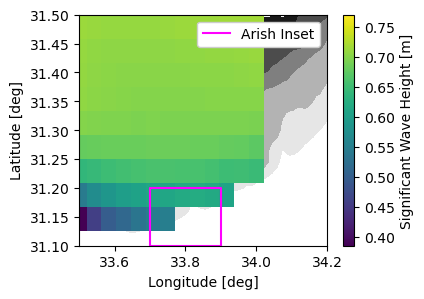

In [19]:
plt.figure(figsize=(4,3))
ax = plt.subplot(111)
plt.contourf(lons[::10], lats[::10], -1*data[::10][:,::10], cmap='binary', levels=np.linspace(4, 100, 6))
m = plt.pcolormesh(nc.longitude, nc.latitude, np.nanmean(nc['VHM0'].values, axis=0), shading='nearest')
cb = plt.colorbar(m)
cb.ax.set_ylabel("Significant Wave Height [m]")
plt.xlabel("Longitude [deg]")
plt.ylabel("Latitude [deg]")
plt.xlim(33.5, 34.2)
plt.ylim(31.1, 31.5)
plt.plot([lonmax, lonmin, lonmin, lonmax, lonmax], [latmin, latmin, latmax, latmax, latmin], color='magenta', label='Arish Inset')
plt.legend(framealpha=1)
plt.show()

For now, let's just focus on the mean swell
1. Direction: VMDR
2. Peak Period: VTPK
3. Significant Wave Height: VHM0

We also need directional spread and spectral shape. Let's assume a JONSWAP spectrum with directional spread of 10 degrees in 5 meters. Let's plot what that looks like:

In [20]:
import waveresponse as wr

hs = np.nanmean(nc['VHM0'])
tp = np.nanmean(nc['VTPK'])
dirp = np.nanmin(nc['VMDR']) # Minimum, to represent refraction towards shore
spread = 10

freq = np.arange(0.01, 1, 0.01)
dirs = np.linspace(0.0, 360.0, endpoint=False)

_, spectrum1d = wr.JONSWAP(freq, freq_hz=True)(hs, tp)
spread_fun = wr.CosineFullSpreading(s=spread, degrees=True)

wave = wr.WaveSpectrum.from_spectrum1d(
    freq,
    dirs,
    spectrum1d,
    spread_fun,
    dirp,
    freq_hz=True,
    degrees=True,
    clockwise=False,
    waves_coming_from=False,
)

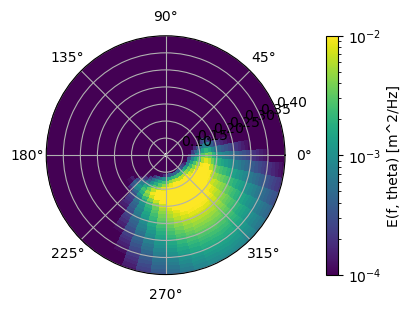

In [21]:
freq, dirs, values = wave.bingrid(freq_hz=True, degrees=True)

fig, axs = plt.subplots(figsize=(4,3), subplot_kw={'projection': 'polar'}, layout='constrained')
cf = plt.pcolormesh(dirs*np.pi/180, freq, values, norm='log', vmax=1e-2, vmin=1e-4, shading='nearest')
cb = plt.colorbar(cf)
cb.ax.set_ylabel("E(f, theta) [m^2/Hz]")
plt.ylim(0.05, 0.4)
plt.show()

What is the direction relative to shoreline? Let's use the 0 m depth contour to get the shoreline facing:

In [22]:
import scipy.stats
import utm

alon = lons[lon_ok]
alat = lats[lat_ok]
adat = data[lat_ok][:,lon_ok]

# Piggyback off of matplotlib to get the 0m depth contour
plt.figure(figsize=(3,3))
cf = plt.contour(alon, alat, adat, colors='black', levels=0)
clon, clat = np.array(cf.allsegs[1][0]).T
plt.close()

# Convert to utm, compute slope again, get facing
ux, uy, _, __ = utm.from_latlon(clat, clon) 
slope_0, intercept, r_value, p_value, std_err = scipy.stats.linregress(ux, uy)
# tan(theta) = o/a = rise/run
# 90 - arctan(slope) should give facing angle
facing = 180*np.arctan(slope_0)/np.pi

print('Facing =', np.around(facing, 2), 'deg')

Facing = 16.14 deg


In [23]:
print('adjusted direction =', np.around(dirp - 270 + facing))

# Evaluate the depths of the nemo output, to guess the effects of shoaling
lolo, lala = np.meshgrid(nc.longitude.values, nc.latitude.values)
wave_depths = interp(np.array([lolo.flatten(), lala.flatten()]).T)
print('at depth =', np.nanmin(wave_depths))

adjusted direction = 48.0
at depth = -129.38177215099353


Okay, that's something to start. High angle! But it will refract towards shore. We need to use Snell's law to estimate the direction in 2 meters.

$$
c_1 = \omega / k_1
$$
$$
c_2 = \omega / k_2
$$
$$
\omega^2 = gk \tanh (kh)
$$
$$
\theta_{2} = \arcsin \left( \frac{c_2}{c_1} \sin \theta_1 \right)
$$

In [24]:
omega = 2*np.pi/tp
g = 9.81

# Shallow water assumption
k_2 = omega / np.sqrt(g * 2)
c_2 = omega/k_2

# Deep water assumption
k_50 = np.sqrt(omega) / g # Approximating what we saw to 50m... 
c_50 = omega/k_50

theta_1 = (dirp - 270 + facing) * np.pi/180
theta_2 = np.arcsin((c_2/c_50)*np.sin(theta_1))

print('shoaled direction = ', theta_2*180/np.pi)

dirp = theta_2*180/np.pi

shoaled direction =  18.84871427900576


Okay! We have the wave direction at our boundary...

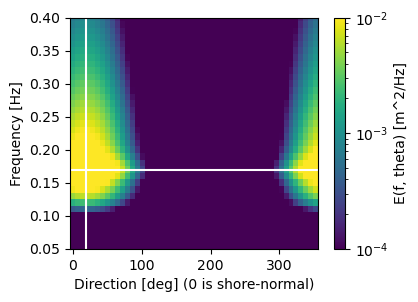

In [25]:
# Generate spectrum, this time with the new directional parameter
freq = np.arange(0.01, 1, 0.01)
dirs = np.linspace(0, 360, endpoint=False)
_, spectrum1d = wr.JONSWAP(freq, freq_hz=True)(hs, tp)
spread_fun = wr.CosineFullSpreading(s=spread, degrees=True)
wave = wr.WaveSpectrum.from_spectrum1d(freq, dirs, spectrum1d, spread_fun, dirp, 
                                       freq_hz=True, degrees=True, clockwise=False, waves_coming_from=False,)
freq, dirs, values = wave.bingrid(freq_hz=True, degrees=True)


plt.figure(figsize=(4,3))
cf = plt.pcolormesh(dirs, freq, values, norm='log', vmax=1e-2, vmin=1e-4, shading='nearest')
cb = plt.colorbar(cf)
cb.ax.set_ylabel("E(f, theta) [m^2/Hz]")
plt.xlabel("Direction [deg] (0 is shore-normal)")
plt.ylabel("Frequency [Hz]")
plt.ylim(0.05, 0.4)
plt.axhline(1/tp, color='white')
plt.axvline(dirp, color='white')
plt.show()

In [26]:
print("[h] =", np.around(hs, 2), 'm')
print("[per] =", np.around(tp,2), 's')
print("[dir] =", int(np.around(theta_2*180/np.pi, 0)), 'deg')
print("[dd] =", spread, 'deg')

[h] = 0.69 m
[per] = 5.89 s
[dir] = 19 deg
[dd] = 10 deg


In SWASH input jargon (see: https://swash.sourceforge.io/online_doc/swashuse/swashuse.html#initial-and-boundary-conditions ), that's 

Note cycle is just the length of the time series SWASH will generate. It should be as long as the simulation. 

## Currents
Are currents important? Let's check...

In [27]:
import copernicusmarine

copernicusmarine.subset(
  dataset_id="cmems_mod_med_phy-cur_anfc_4.2km_PT15M-i",
  variables=["uo", "vo"],
  minimum_longitude=33.0,
  maximum_longitude=34.0,
  minimum_latitude=30.5,
  maximum_latitude=31.5,
  start_datetime="2025-08-05",
  end_datetime="2025-08-10",
  output_directory="./data",
  output_filename="currents_forecast.nc"
)

INFO - 2025-08-04T01:31:48Z - Selected dataset version: "202411"
INFO - 2025-08-04T01:31:48Z - Selected dataset part: "default"
WARNING - 2025-08-04T01:31:48Z - Some of your subset selection [2025-08-05 00:00:00+00:00, 2025-08-10 00:00:00+00:00] for the time dimension exceed the dataset coordinates [2022-11-01 00:00:00+00:00, 2025-08-07 23:45:00+00:00]
INFO - 2025-08-04T01:31:51Z - Starting download. Please wait...
INFO - 2025-08-04T01:31:59Z - Successfully downloaded to data/currents_forecast.nc


ResponseSubset(file_path=PosixPath('data/currents_forecast.nc'), output_directory=PosixPath('data'), filename='currents_forecast.nc', file_size=1.3320839694656488, data_transfer_size=100.55523664122137, variables=['uo', 'vo'], coordinates_extent=[GeographicalExtent(minimum=33.0, maximum=34.0, unit='degrees_east', coordinate_id='longitude'), GeographicalExtent(minimum=30.52083396911621, maximum=31.47916603088379, unit='degrees_north', coordinate_id='latitude'), TimeExtent(minimum='2025-08-05T00:00:00+00:00', maximum='2025-08-07T23:45:00+00:00', unit='iso8601', coordinate_id='time')], status='000', message='The request was successful.', file_status='DOWNLOADED')

/tmp/ipykernel_833309/2821221925.py:6: RuntimeWarning: Mean of empty slice
  u_avg = np.nanmean(nc['uo'].values, axis=0)
/tmp/ipykernel_833309/2821221925.py:7: RuntimeWarning: Mean of empty slice
  v_avg = np.nanmean(nc['vo'].values, axis=0)


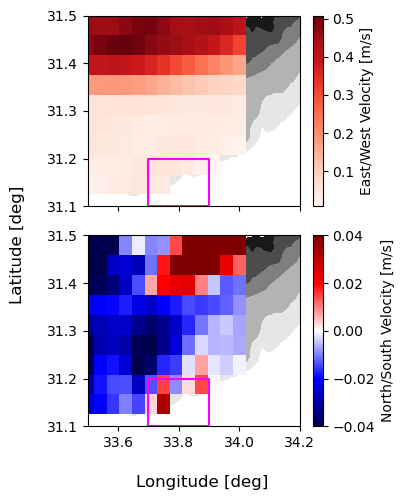

In [28]:
ncf = './data/currents_forecast.nc'
nc = xr.open_dataset(ncf)

clon = nc.longitude.values
clat = nc.latitude.values
u_avg = np.nanmean(nc['uo'].values, axis=0)
v_avg = np.nanmean(nc['vo'].values, axis=0)

# Plot
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(4,5))
axs[0].contourf(lons[::10], lats[::10], -1*data[::10][:,::10], cmap='binary', levels=np.linspace(4, 100, 6))
axs[1].contourf(lons[::10], lats[::10], -1*data[::10][:,::10], cmap='binary', levels=np.linspace(4, 100, 6))
m0 = axs[0].pcolormesh(clon, clat, u_avg, cmap='Reds')
cb = plt.colorbar(m0, ax=axs[0])
cb.ax.set_ylabel("East/West Velocity [m/s]")
m1 = axs[1].pcolormesh(clon, clat, v_avg, cmap='seismic', vmin=-0.04, vmax=0.04)
cb = plt.colorbar(m1, ax=axs[1])
cb.ax.set_ylabel("North/South Velocity [m/s]")
fig.supxlabel("Longitude [deg]")
fig.supylabel("Latitude [deg]")
plt.xlim(33.5, 34.2)
plt.ylim(31.1, 31.5)
axs[0].plot([lonmax, lonmin, lonmin, lonmax, lonmax], [latmin, latmin, latmax, latmax, latmin], color='magenta')
axs[1].plot([lonmax, lonmin, lonmin, lonmax, lonmax], [latmin, latmin, latmax, latmax, latmin], color='magenta')
plt.tight_layout()
plt.show()

Because this is NEMO / Copernicus, I'm guessing the primary modeling term is geostrophic flow. This flow is highly pixelated near the coast, and very small in general. The eastern Mediterranean current doesn't get big until 50-100 meters depth. So I'm going to assume no geostrophic flow matters in the coastal zone, and we're only concerned with wind and waves until 50m depth.

# SWASH INPUTS

For each SWASH run, there are 3 files needed:
1. Coordinates
2. Bathymetry
3. ini (i.e. the config file)

Because we're using a parametric spectrum, we don't need to generate any files for the boundary.  

Step 1 is to get our helper functions

In [29]:
# Helper Functions
import os

def ensure_dir(path):
    dir = os.path.dirname(path)
    if not os.path.exists(dir):
        os.makedirs(dir)
        
def format_time(t):
    hours = int(t/3600)
    minutes = int(t/60 % 60)
    seconds = int(t % 60)
    ms = int(1000*(t % 1))
    return str(hours).zfill(2) + str(minutes).zfill(2) + str(seconds).zfill(2) + '.' + str(ms).zfill(3)

# Get a function for evaluating characteristic depth
beta = 0.00436
hc = lambda x : x*beta

# Prepare a directory for the test
test_dir = './swash_test/'
ensure_dir(test_dir)

Decisions need to be made about the cross-shore resolution. A good practice is to evaluate the wavelength for a characteristic frequency and get a resolution with 20-50 grid cells per wavelength. 

In [30]:
g = 9.81
def k_sw(omega, h):
    return omega / np.sqrt(g*np.abs(h))
# in deep water, kh is BIG, tanh(kh) approx 1
def k_deep(omega, h):
    return omega**2 / g

f_characteristic = 1/5 # assume 5 second waves we care about
n_pixels = 10 # high accuracy would be 50 but for speed, using far fewer
dx_min = 0.5 # also very painful for accuracy but its fine
dx_max = 100 # Not gonna get close to this...

def dx(h):
    """
    Given depth h, suggest a grid resolution
    """
    k = k_sw(2*np.pi*f_characteristic, h)
    L = 2*np.pi/k
    provisional_dx = L / n_pixels
    if provisional_dx > dx_max: 
        return dx_max
    elif provisional_dx < dx_min: 
        return dx_min
    else: 
        return provisional_dx

The along-shore coordinate will be fixed at 2.5 meters. We need some alongshore resolution to resolve flows near the groyn.

That means we can generate the computational grid

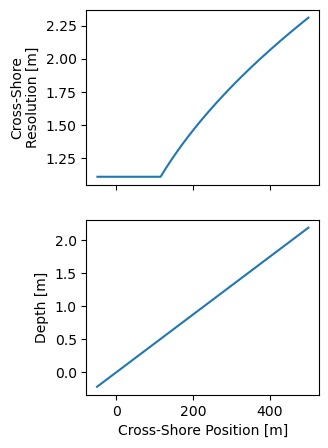

In [31]:
# Generate profile using dx(x)
x = [-50]
while x[-1] < 500:
    h = hc(x[-1])
    if h < .5:
        h = .5
    x.append(x[-1] + dx(h))
x = np.array(x)    

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(3,5))
axs[0].plot(x[1:], np.diff(x))
axs[0].set_ylabel("Cross-Shore\nResolution [m]")
axs[1].plot(x, hc(x))
axs[1].set_ylabel("Depth [m]")
axs[1].set_xlabel("Cross-Shore Position [m]")
plt.show()

Decide y coordinate and make grid

In [32]:
dy = 2.5
Ly = 160
y = np.linspace(-0.5*Ly, 0.5*Ly, int(Ly/dy))

In [33]:
print("Number x coordinates:", len(x))
print("Number y coordinates:", len(y))

Number x coordinates: 376
Number y coordinates: 64


Need to interpolate the simplified groyn bathy onto the grid

In [34]:
bathy_interp = scipy.interpolate.RegularGridInterpolator([xrange, yrange], zz_s.T, bounds_error=False, fill_value=None)
zz = np.array([bathy_interp(np.array([x, np.ones(len(x))*yp]).T) for yp in y])
xx, yy = np.meshgrid(x, y)

In [35]:
import pandas as pd

# reduce accuracy for x,y (high accuracy not necessary)
xx = np.around(xx, 1)
yy = np.around(yy, 1)

# Create and save grid file
grid_data = {}
for i in range(len(x)):
    grid_data.update({i:np.append(xx[:,i], yy[:,i])})
grid_2d_df = pd.DataFrame.from_dict(grid_data)
grid_2d_df.to_csv(test_dir+'coords.txt', sep=' ', header=False, index=False)

# Bathy
bot_2d_df = pd.DataFrame.from_dict({str(i):zz[:,i] for i in range(len(x))})
bot_2d_df.to_csv(test_dir+'bathy.txt', sep=' ', header=False, index=False)    

Great, now we just need the input file. I'll start by loading a template I made for fairly good physics..

In [36]:
input_template_file = open('./template.txt')
input_template = input_template_file.read()
print(input_template)

$
$*************** INPUT *********************
$
PROJ 'default' '01'
MODE NONSTationary TWODimensional
$
CGRID CURV {mxc} {myc} REP Y
READgrid COORdinates 1 'coords.txt' 1 0 0 FREE
VERT 2
INPgrid BOTtom CURV 
READinp BOTtom -1 'bathy.txt' 1 0 FREE
SET depmin = 0.010
SET level = 0
{bc_str}
$
$*************** PHYSICS *********************
$
FRIC MANN 0.019
SET BACKVISC 1.e-4
BREAK 0.6 0.3
VISC VERT KEPS
$
$*************** NUMERICS *********************
$
NONHYDROSTATIC BOX 1. PRECONDITIONER ILU
DISCRET CORRDEP MUSCL 
DISCRET UPW UMOM MOM VERT FIR
DISCRET UPW UMOM MOM HOR MUSCL
DISCRET UPW WMOM VERT FIR
DISCRET UPW WMOM HOR MUSCL
TIMEI 0.4 0.8
$
$
$************ OUTPUT REQUESTS *************************  
$
BLOCK 'COMPGRID' NOHEAD 'output.mat' XP YP BOTL WATL VKSIK VETAK HK OUTPUT 000000.000 0.5 SEC
TEST 1 0
COMPUTE 000000.000 0.01 SEC {timestr}
STOP



In [37]:
# Prepare stuff to inject in string

# Time string -- specify how long to run the model
model_time = 45*60 # Let's start with 45 minutes...
hours, minutes, seconds = int(model_time/3600), int(model_time/60 - 60*int(model_time/3600)), model_time%60
timestr = "{hours:02d}{minutes:02d}{seconds:02d}.000".format(hours=hours, minutes=minutes, seconds=seconds)

# The grid shape
mxc, myc     = len(x)-1, len(y)-1

# Where to specify the boundary condition. Offshore boundary. Index space. 
i0 = mxc + 1
i1 = mxc + 1
j0 = 1
j1 = myc + 1

# The boundary condition itself
h = np.around(hs, 2)
per = np.around(tp,2)
d = 180 + int(np.around(theta_2*180/np.pi, 0))
dd = 10
cycle = model_time
bcstr = ("BOUnd SHAPespec JONswap 3.3 SIG PEAK DSPR DEGRees \n" + 
         "BOUndcond SEGMent IJ " + 
         str(i0) + " " + str(j0) + ' '  + str(i1) + ' ' + str(j1) + 
         " BTYPe WEAKrefl CONstant SPECTrum " +
         str(h) + " " + str(per) + " " + str(d) + " " + str(dd) + " " + str(cycle) + " SEC \n")

# inject string
input_file_content = input_template.format(mxc = int(mxc), myc = int(myc), 
                                           timestr=timestr, bc_str=bcstr)
input_file = open(test_dir+'INPUT', "w")
input_file.write(input_file_content)
input_file.close()

# Show what we wrote...
print(input_file_content)

$
$*************** INPUT *********************
$
PROJ 'default' '01'
MODE NONSTationary TWODimensional
$
CGRID CURV 375 63 REP Y
READgrid COORdinates 1 'coords.txt' 1 0 0 FREE
VERT 2
INPgrid BOTtom CURV 
READinp BOTtom -1 'bathy.txt' 1 0 FREE
SET depmin = 0.010
SET level = 0
BOUnd SHAPespec JONswap 3.3 SIG PEAK DSPR DEGRees 
BOUndcond SEGMent IJ 376 1 376 64 BTYPe WEAKrefl CONstant SPECTrum 0.69 5.89 199 10 2700 SEC 

$
$*************** PHYSICS *********************
$
FRIC MANN 0.019
SET BACKVISC 1.e-4
BREAK 0.6 0.3
VISC VERT KEPS
$
$*************** NUMERICS *********************
$
NONHYDROSTATIC BOX 1. PRECONDITIONER ILU
DISCRET CORRDEP MUSCL 
DISCRET UPW UMOM MOM VERT FIR
DISCRET UPW UMOM MOM HOR MUSCL
DISCRET UPW WMOM VERT FIR
DISCRET UPW WMOM HOR MUSCL
TIMEI 0.4 0.8
$
$
$************ OUTPUT REQUESTS *************************  
$
BLOCK 'COMPGRID' NOHEAD 'output.mat' XP YP BOTL WATL VKSIK VETAK HK OUTPUT 000000.000 0.5 SEC
TEST 1 0
COMPUTE 000000.000 0.01 SEC 004500.000
STOP



## Read Output
Need to turn from binary output (matlab) to netcdf. 

In [80]:
# Load the matlab file
maf = test_dir+'output.mat'
m = scipy.io.loadmat(maf)

# The data we are gonna get out of the output file -- formatted as keys...
dtypes = ['Watlev', 'Vksi_k1', 'Vksi_k2', 'Veta_k1', 'Veta_k2', 'hk1', 'hk2']

# Get x and y coordinates. 
x = np.unique(m['Xp'])
y = np.unique(m['Yp'])

# Parse each key in the matlab file to grab the timestamp
t = []
for key_str in list(m.keys())[6:]:
    key_str_split = key_str.split('_')
    milliseconds = np.timedelta64( int(key_str_split[-1]),         'ms')
    seconds      = np.timedelta64( int(key_str_split[-2][-2:]),    's')
    minutes      = np.timedelta64( int(key_str_split[-2][-4:-2]),  'm')
    hours        = np.timedelta64( int(key_str_split[-2][-6:-4]),  'h')
    td = np.timedelta64(hours + minutes + seconds + milliseconds)
    t.append(td)
t = np.unique(t)
t = np.array(t).astype('timedelta64[ms]')

# Make a list for each datatype I'm reading
v1, v2 = [], []
u1, u2 = [], []
eta = []
h1, h2 = [], []
lists = [eta, u1, u2, v1, v2, h1, h2]

# Read each key in the matlab file, classify and put in correct list
for key_str in list(m.keys())[3:]:
    for d, l in zip(dtypes, lists):
        if d in key_str:
            l.append(m[key_str])

# Cast to numpy arrays
eta = np.array(eta)
u1 = np.array(u1)
v1 = np.array(v1)
u2 = np.array(u2)
v2 = np.array(v2)
h1 = np.array(h1)
h2 = np.array(h2)

# Average currents
u_avg = (u1*h1 + u2*h2) / (h1 + h2)
v_avg = (v1*h1 + v2*h2) / (h1 + h2)
z_bottom = m['Botlev']

# Write to a netcdf file
data_dict = {  'eta': (['t', 'y', 'x'], eta  ),
             'u_avg': (['t', 'y', 'x'], u_avg),
             'v_avg': (['t', 'y', 'x'], v_avg),
             'z_bed': ([     'y', 'x'], z_bottom) }
coords_dict = {'x':x, 'y':y, 't':t}
out_ds = xr.Dataset(data_dict, coords=coords_dict)
out_ds.to_netcdf(test_dir + 'output.nc')

01:45:39 WARNING py.warnings:110: /home/cassandra/anaconda3/envs/opendrift/lib/python3.13/site-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "Xp" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)

01:45:39 WARNING py.warnings:110: /home/cassandra/anaconda3/envs/opendrift/lib/python3.13/site-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "Yp" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)

01:45:39 WARNING py.warnings:110: /home/cassandra/anaconda3/envs/opendrift/lib/python3.13/site-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "Botlev" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable 

In [81]:
out_ds

<xarray.Dataset> Size: 2GB
Dimensions:  (t: 5400, y: 64, x: 376)
Coordinates:
  * x        (x) float32 2kB -50.0 -48.9 -47.8 -46.7 ... 494.4 496.7 499.0 501.3
  * y        (y) float32 256B -80.0 -77.5 -74.9 -72.4 ... 72.4 74.9 77.5 80.0
  * t        (t) timedelta64[ms] 43kB 00:00:00 ... 00:44:59.500000
Data variables:
    eta      (t, y, x) float32 520MB 0.2093 0.2079 0.2052 ... 0.3277 0.3355
    u_avg    (t, y, x) float32 520MB 0.0 0.0 0.0 0.0 ... -0.5108 -0.5624 -0.3607
    v_avg    (t, y, x) float32 520MB 0.0 0.0 0.0 0.0 ... -0.197 -0.1061 -0.03768
    z_bed    (y, x) float32 96kB -0.2006 -0.1981 -0.1954 ... 2.154 2.16 2.166

Sanity Plot

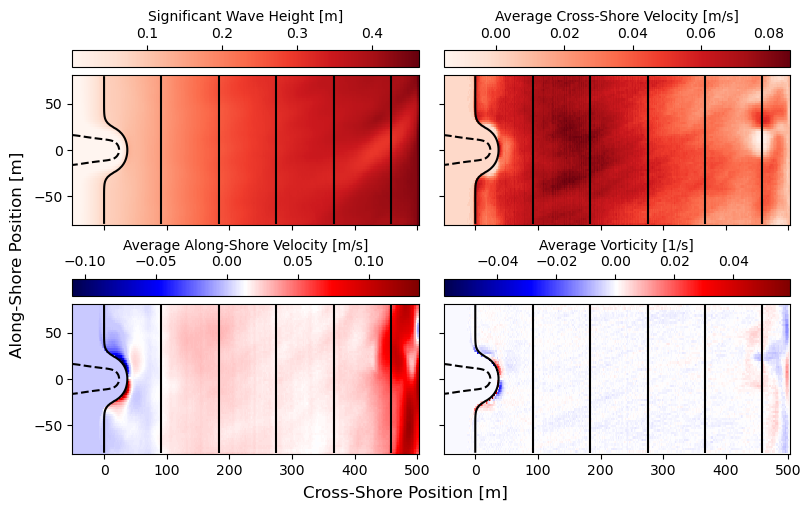

In [82]:
Hs = 4*np.nanstd(out_ds.eta.values, axis=0)
u_avg = np.nanmedian(out_ds.u_avg.values, axis=0)
v_avg = np.nanmedian(out_ds.v_avg.values, axis=0)

#
u_avg[Hs == 0] = 0
v_avg[Hs == 0] = 0

# vorticity = dv/dx - du/dy
dvdx = np.diff(v_avg, axis=1)/np.diff(x)[np.newaxis,:]
dudy = np.diff(u_avg, axis=0)/np.diff(y)[:,np.newaxis]
vort = dvdx[1:,:] - dudy[:,1:]

fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, constrained_layout=True, figsize=(8,5))
axs = axs.flatten()

m = axs[0].pcolormesh(x, y, Hs, shading='nearest', cmap='Reds')
axs[0].contour(x, y, z_bottom, colors='black')
cb = plt.colorbar(m, ax=axs[0], location='top')
cb.ax.set_xlabel("Significant Wave Height [m]")

m = axs[1].pcolormesh(x, y, u_avg, shading='nearest', cmap='Reds') #, vmin=-0.03, vmax=0.03)
axs[1].contour(x, y, z_bottom, colors='black')
cb = plt.colorbar(m, ax=axs[1], location='top')
cb.ax.set_xlabel("Average Cross-Shore Velocity [m/s]")

m = axs[2].pcolormesh(x, y, v_avg, shading='nearest', cmap='seismic') #, vmin=-0.06, vmax=0.06)
axs[2].contour(x, y, z_bottom, colors='black')
cb = plt.colorbar(m, ax=axs[2], location='top')
cb.ax.set_xlabel("Average Along-Shore Velocity [m/s]")

m = axs[3].pcolormesh(x, y, vort, cmap='seismic') #, vmin=-0.06, vmax=0.06)
axs[3].contour(x, y, z_bottom, colors='black')
cb = plt.colorbar(m, ax=axs[3], location='top')
cb.ax.set_xlabel("Average Vorticity [1/s]")

fig.supxlabel("Cross-Shore Position [m]")
fig.supylabel("Along-Shore Position [m]")
plt.show()

Interestingly, this sort of suggests that regardless of wave direction, you are best served by tossing from a groyn -- and either direction is the same. 

Ideally at this point I would check the boundary condition successfully reproduced the requested boundary. I'd also make a video for visual inspection. However given this is a proof of concept, I'll move immediately towards testing with a drifter. 

To do that I need a netcdf file with latlon coordinates. Let's prep that... First I need to repeat alongshore a bunch of times...

In [83]:
# Decide new y (alongshore) coordinates over which to repeat
new_y = np.linspace(-1000, 1000, 1001)
y_interp = np.mod(new_y, 160) - 80

# Not changing x
new_x = x

# Meshgrid using the interp, which only goes over the valid values.
nxx, nyy = np.meshgrid(new_x, y_interp)

# Interpolate to repeat a few times alongshore...
u_interp = scipy.interpolate.RegularGridInterpolator([x,y], u_avg.T)
v_interp = scipy.interpolate.RegularGridInterpolator([x,y], v_avg.T)
nu = u_interp(np.array([nxx.flatten(), nyy.flatten()]).T).reshape(nxx.shape)
nv = v_interp(np.array([nxx.flatten(), nyy.flatten()]).T).reshape(nxx.shape)

Now convert from x,y problem grid to lat lon, by rotating by the beach facing direction, then converting...

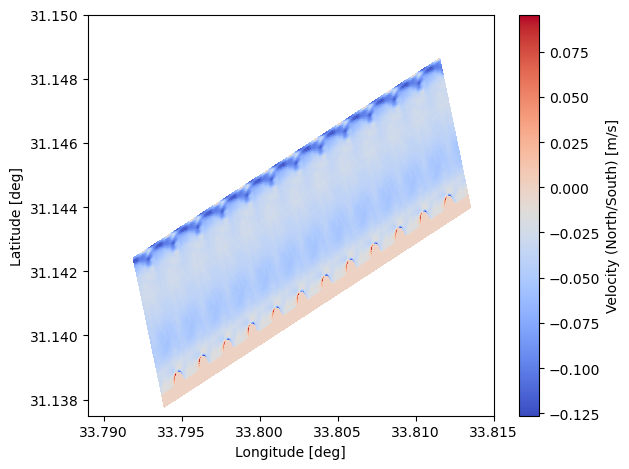

In [84]:
xx, yy = np.meshgrid(new_x, new_y)

# Rotate
theta = 180 + facing * np.pi / 180
RotMatrix = np.array([[np.cos(theta),  np.sin(theta)],
                      [-np.sin(theta), np.cos(theta)]])

# Need to rotate both x,y coordinates and u,v velocities. 
xx, yy = np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([xx, yy]))
nu, nv = np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([nu, nv]))

# Get the offset
x0, y0, _, __ = utm.from_latlon(lat0, lon0)

# Convert to latlon
lala, lolo = utm.to_latlon(x0+xx, y0+yy, _, __)

# Plot
plt.figure()
# plt.contourf(lons[::10], lats[::10], -1*data[::10][:,::10], cmap='binary', levels=np.linspace(4, 100, 6))
m = plt.pcolormesh(lolo, lala, nu, cmap='coolwarm', shading='nearest')
cb = plt.colorbar(m)
cb.ax.set_ylabel("Velocity (North/South) [m/s]")
plt.xlim(33.789, 33.815)
plt.ylim(31.1375, 31.15)
plt.xlabel("Longitude [deg]")
plt.ylabel("Latitude [deg]")
plt.show()

In [86]:
# Get time average velocities, which is what we'll use for these purposes
# I've already time-averaged them, so not necessary

# Reproject onto a latlon grid
la_range = np.linspace(np.nanmin(lala), np.nanmax(lala), 1000)
lo_range = np.linspace(np.nanmin(lolo), np.nanmax(lolo), 1000)

lo_grid, la_grid = np.meshgrid(lo_range, la_range)

u_interp = scipy.interpolate.griddata(np.array([lolo.flatten(), lala.flatten()]).T, 
                                      nu.flatten(), 
                                      np.array([lo_grid.flatten(), la_grid.flatten()]).T).reshape(lo_grid.shape)

v_interp = scipy.interpolate.griddata(np.array([lolo.flatten(), lala.flatten()]).T, 
                                      nv.flatten(), 
                                      np.array([lo_grid.flatten(), la_grid.flatten()]).T).reshape(lo_grid.shape)

# Save as netcdf... we're gonna spoof some datetimes, assume everything is the same...
t0 = np.datetime64('2025-07-01')
tf = np.datetime64('2025-07-30')
time = np.arange(t0, tf, np.timedelta64(24, 'h'))

# Project onto the fake grid
u_out = u_interp[np.newaxis,:,:] + np.ones((len(time), len(lo_grid), len(la_grid)))
v_out = v_interp[np.newaxis,:,:] + np.ones((len(time), len(lo_grid), len(la_grid)))

# Out to netcdf
data_dict = {'uo': (['time', 'latitude', 'longitude'], u_out),
             'vo': (['time', 'latitude', 'longitide'], v_out)}
coords_dict = {'longitude':lo_range, 'latitude':la_range, 't':time}
out_ds = xr.Dataset(data_dict, coords=coords_dict)
out_ds.to_netcdf(test_dir + 'output_for_drifter.nc')

## Drifter Test

### Wind 

Before moving forward, I need a wind term to transport offshore, otherwise no drifters will ever get offshore. SWASH 2D has provided stokes drift and small scale circulation, but wind needs to come from Copernicus. I'll start by downloading that...

Note that, unlike the wave or current product, this is not a forecast. I'm going to try to estimate the diurnal pattern rather than a specific time

In [44]:
import copernicusmarine

ds_wind = copernicusmarine.subset(
    dataset_id="cmems_obs-wind_glo_phy_nrt_l4_0.125deg_PT1H",
    variables=["eastward_wind", "northward_wind"],  # 10m wind components eastward and northward
    minimum_longitude=33.0,
    maximum_longitude=34.0,
    minimum_latitude=30.5,
    maximum_latitude=31.5,
    start_datetime="2025-07-05",
    end_datetime="2025-07-25",
    output_directory="./data",
    output_filename="wind.nc"
)

INFO - 2025-08-04T01:32:29Z - Selected dataset version: "202207"
INFO - 2025-08-04T01:32:29Z - Selected dataset part: "default"
INFO - 2025-08-04T01:32:32Z - Starting download. Please wait...
INFO - 2025-08-04T01:32:33Z - Successfully downloaded to data/wind.nc


In [87]:
nc = xr.open_dataset("./data/wind.nc")
ewind = np.nanmean(np.nanmean(nc.eastward_wind.values, axis=1), axis=1)
nwind = np.nanmean(np.nanmean(nc.northward_wind.values, axis=1), axis=1)
time = nc.time.values
tf = (time - time[0]).astype('timedelta64[s]').astype(float)
nc

<xarray.Dataset> Size: 496kB
Dimensions:         (time: 481, latitude: 8, longitude: 8)
Coordinates:
  * latitude        (latitude) float32 32B 30.56 30.69 30.81 ... 31.31 31.44
  * longitude       (longitude) float32 32B 33.06 33.19 33.31 ... 33.81 33.94
  * time            (time) datetime64[ns] 4kB 2025-07-05 ... 2025-07-25
Data variables:
    eastward_wind   (time, latitude, longitude) float64 246kB -1.15 ... 3.66
    northward_wind  (time, latitude, longitude) float64 246kB -0.03 ... 0.94
Attributes:
    institution:               Royal Netherlands Meteorological Institute (KNMI)
    Conventions:               CF-1.6, ACDD-1.3
    history:                   N/A
    title:                      Global Ocean - Wind and Stress - Hourly - Fro...
    references:                Copernicus Marine Service Product User Manual ...
    copernicusmarine_version:  2.2.1

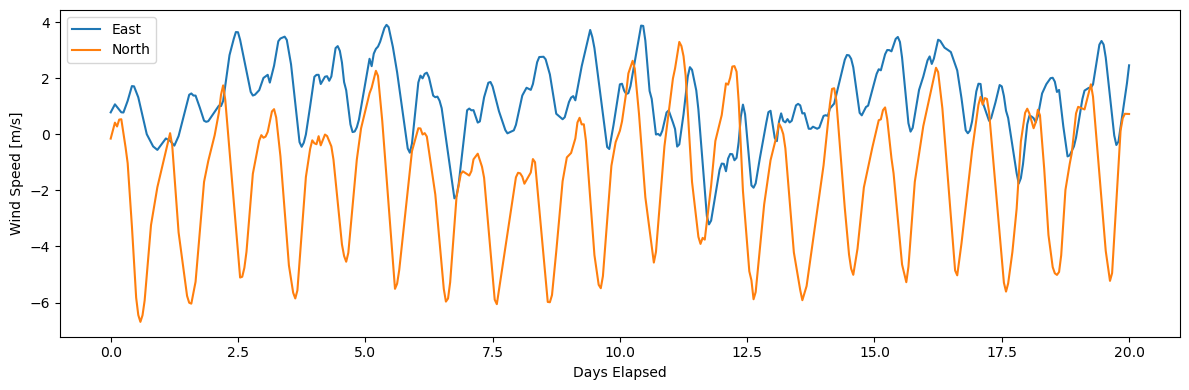

In [88]:
plt.figure(figsize=(12,4))
plt.plot(tf/(24*3600), ewind, label='East')
plt.plot(tf/(24*3600), nwind, label='North')
plt.legend()
plt.ylabel("Wind Speed [m/s]")
plt.xlabel("Days Elapsed")
plt.show()

Let's assume a drifter release under ideal conditions, which would be north winds around 2-4 m/s. Let's say 3 +- 1

In [89]:
ideal_t = time[np.argmax(nwind)]
print('max wind time = ', ideal_t)

max wind time =  2025-07-16T04:00:00.000000000


from opendrift.models.oceandrift import OceanDrift
from opendrift.readers.reader_netCDF_CF_generic import Reader

In [90]:
currents_file = test_dir + 'output_for_drifter.nc'
wind_file = "./data/wind.nc"

01:46:23 INFO    opendrift:513: OpenDriftSimulation initialised (version 1.14.2 / v1.14.2-90-g1dd1995)
01:46:23 INFO    opendrift.readers:61: Opening file with xr.open_dataset
01:46:23 INFO    opendrift.readers.reader_netCDF_CF_generic:299: Grid coordinates are detected, but proj4 string not given: assuming latlong
01:46:23 INFO    opendrift.readers.reader_netCDF_CF_generic:332: Detected dimensions: {'y': 'latitude', 'x': 'longitude', 'time': 'time'}
01:46:23 INFO    opendrift.readers.basereader:176: Variable x_wind will be rotated from eastward_wind
01:46:23 INFO    opendrift.readers.basereader:176: Variable y_wind will be rotated from northward_wind
01:46:23 INFO    opendrift.models.basemodel.environment:206: Adding a global landmask from GSHHG
01:46:23 INFO    opendrift.models.basemodel.environment:229: Fallback values will be used for the following variables which have no readers: 
01:46:23 INFO    opendrift.models.basemodel.environment:232: 	x_sea_water_velocity: 0.000000
01:46:23

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2025-07-15 20:00 to 2025-07-17 20:00 UTC (289 steps)'}>,
 <Figure size 1100x707.095 with 1 Axes>)

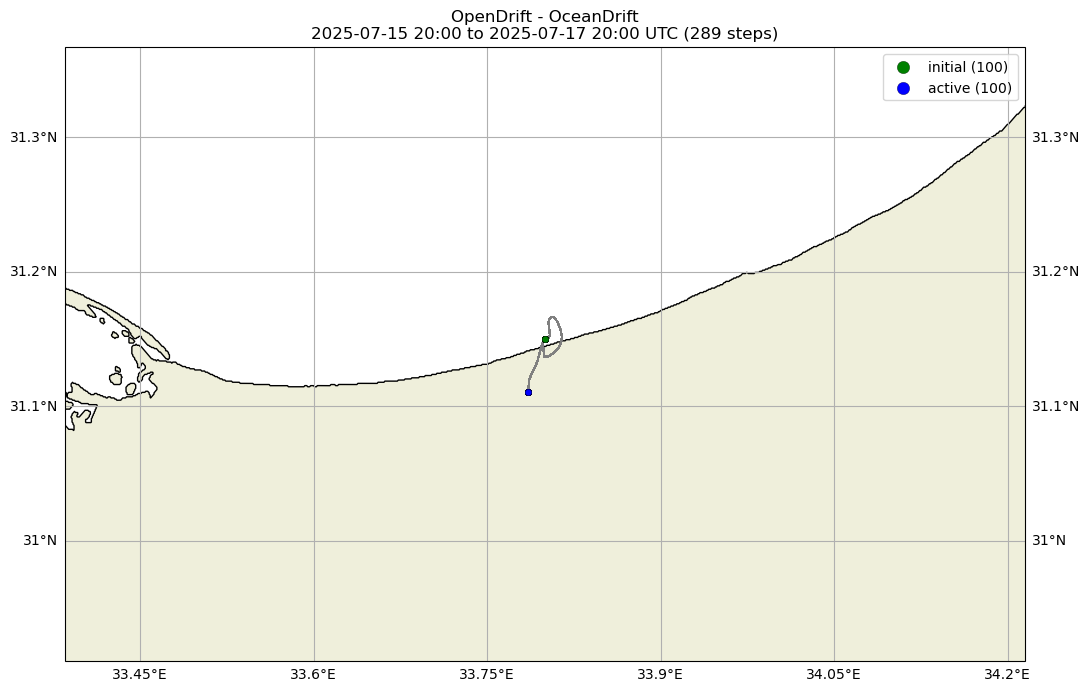

In [91]:
from datetime import datetime, timedelta
from opendrift.models.oceandrift import OceanDrift
from opendrift.readers.reader_netCDF_CF_generic import Reader

# Create OpenDrift model instance
o = OceanDrift(loglevel=20)

# Ocean currents
#currents = Reader(currents_file)

# Wind
wind = Reader(wind_file)

o.set_config('general:coastline_action', 'none')

# Add readers to model
o.add_reader([wind])

# Simulation details
duration = timedelta(days=2)

# Where to release... 
n = 100
lon_center, lat_center = 33.800, 31.140
spread = 0.0001  # degrees

lons = lon_center + (np.random.rand(n) - 0.5) * spread
lats = lat_center + (np.random.rand(n) - 0.5) * spread

release_time = pd.Timestamp(ideal_t  - np.timedelta64(8, 'h')).to_pydatetime()

o.set_config('seed:wind_drift_factor', 100)      # higher wind effect for small buoy

o.seed_elements(lon=lons, lat=lats, number=n, time=release_time)


# Run simulation
o.run(duration=duration, time_step=600)

# Plot results
o.plot(fast=False, filename='drifter_waves_wind.png')
